In [ ]:
import os

# Create data folder if not exists
os.makedirs("data", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("scalers", exist_ok=True)

print("Folders ready!")


Folders ready!


In [ ]:
from google.colab import files
uploaded = files.upload()

# Move uploaded files to /data folder
for fn in uploaded.keys():
    os.rename(fn, os.path.join("data", fn))

print("Files uploaded to /data folder!")


Saving test_FD001.txt to test_FD001.txt
Saving train_FD001.txt to train_FD001.txt
Saving RUL_FD001.txt to RUL_FD001.txt
Files uploaded to /data folder!


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import joblib
import math, glob


In [ ]:
# Data integrity check - important for Milestone 1
print("Missing values per column:")
print(df.isna().sum())


Missing values per column:
unit            0
cycle           0
op_setting_1    0
op_setting_2    0
op_setting_3    0
s1              0
s2              0
s3              0
s4              0
s5              0
s6              0
s7              0
s8              0
s9              0
s10             0
s11             0
s12             0
s13             0
s14             0
s15             0
s16             0
s17             0
s18             0
s19             0
s20             0
s21             0
RUL             0
RUL_cap         0
dtype: int64


In [ ]:
def read_cmapss(file_path):
    col_names = ["unit","cycle",
                 "op_setting_1","op_setting_2","op_setting_3"] + \
                [f"s{i}" for i in range(1,22)]
    df = pd.read_csv(file_path, sep=r"\s+", header=None, names=col_names)
    return df

def add_rul(df):
    max_c = df.groupby("unit")["cycle"].max().reset_index()
    max_c.columns = ["unit","max_cycle"]
    df = df.merge(max_c,on="unit")
    df["RUL"] = df["max_cycle"] - df["cycle"]
    df.drop("max_cycle",axis=1,inplace=True)
    return df

train_file = "data/train_FD001.txt"
df = read_cmapss(train_file)
df = add_rul(df)

df.head()


,unit,cycle,op_setting_1,op_setting_2,op_setting_3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [ ]:
CAP_RUL = 125
SEQ_LEN = 50

sensor_cols = [c for c in df.columns if c.startswith("s") or c.startswith("op_")]

df["RUL_cap"] = df["RUL"].clip(upper=CAP_RUL)

scaler_fd001 = StandardScaler()
scaler_fd001.fit(df[sensor_cols])
df[sensor_cols] = scaler_fd001.transform(df[sensor_cols])

def create_sequences(df):
    Xs, ys = [], []
    for u in sorted(df["unit"].unique()):
        temp = df[df["unit"] == u].sort_values("cycle")
        data, labels = temp[sensor_cols].values, temp["RUL_cap"].values
        if len(data) < SEQ_LEN: continue
        for i in range(len(data) - SEQ_LEN + 1):
            Xs.append(data[i:i+SEQ_LEN])
            ys.append(labels[i+SEQ_LEN-1])
    return np.array(Xs), np.array(ys)

X, y = create_sequences(df)
print("Sequence Data:", X.shape, y.shape)


Sequence Data: (15731, 50, 24) (15731,)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=42
)
print(X_train.shape, X_val.shape)


(13371, 50, 24) (2360, 50, 24)


In [ ]:
tf.keras.backend.clear_session()

model_fd001 = Sequential([
    GRU(128, input_shape=(SEQ_LEN, len(sensor_cols))),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dense(1)
])

model_fd001.compile(optimizer="adam", loss="mse")

checkpoint_fd001 = ModelCheckpoint(
    "models/best_FD001.h5", monitor="val_loss", save_best_only=True
)

history = model_fd001.fit(
    X_train, y_train,
    epochs=30, batch_size=128,  # 🔥 changed epochs to 30
    validation_data=(X_val, y_val),
    callbacks=[checkpoint_fd001],
    verbose=2
)

joblib.dump(scaler_fd001, "scalers/scaler_FD001.joblib")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30


105/105 - 20s - 190ms/step - loss: 3202.1987 - val_loss: 831.9744
Epoch 2/30


105/105 - 15s - 145ms/step - loss: 548.8649 - val_loss: 442.7314
Epoch 3/30
105/105 - 21s - 198ms/step - loss: 345.7460 - val_loss: 646.8151
Epoch 4/30


105/105 - 16s - 151ms/step - loss: 327.9648 - val_loss: 218.7934
Epoch 5/30


105/105 - 15s - 145ms/step - loss: 285.0319 - val_loss: 181.5888
Epoch 6/30
105/105 - 15s - 145ms/step - loss: 272.3284 - val_loss: 208.4595
Epoch 7/30
105/105 - 16s - 155ms/step - loss: 278.3885 - val_loss: 210.5007
Epoch 8/30


105/105 - 17s - 158ms/step - loss: 233.9529 - val_loss: 170.9500
Epoch 9/30


105/105 - 20s - 188ms/step - loss: 240.8898 - val_loss: 153.5376
Epoch 10/30


105/105 - 15s - 146ms/step - loss: 218.3373 - val_loss: 134.0394
Epoch 11/30


105/105 - 15s - 148ms/step - loss: 204.8399 - val_loss: 125.0371
Epoch 12/30
105/105 - 17s - 157ms/step - loss: 194.5022 - val_loss: 183.5334
Epoch 13/30


105/105 - 16s - 150ms/step - loss: 190.6775 - val_loss: 124.7117
Epoch 14/30


105/105 - 15s - 145ms/step - loss: 193.6511 - val_loss: 119.0797
Epoch 15/30
105/105 - 15s - 145ms/step - loss: 187.0766 - val_loss: 158.5688
Epoch 16/30
105/105 - 16s - 150ms/step - loss: 204.3295 - val_loss: 142.1969
Epoch 17/30
105/105 - 21s - 196ms/step - loss: 166.2585 - val_loss: 133.5353
Epoch 18/30


105/105 - 16s - 151ms/step - loss: 158.2187 - val_loss: 115.5569
Epoch 19/30
105/105 - 21s - 197ms/step - loss: 164.8487 - val_loss: 130.3540
Epoch 20/30


105/105 - 15s - 144ms/step - loss: 153.5583 - val_loss: 85.9236
Epoch 21/30


105/105 - 21s - 201ms/step - loss: 137.1065 - val_loss: 82.5913
Epoch 22/30


105/105 - 17s - 159ms/step - loss: 136.3094 - val_loss: 73.8561
Epoch 23/30
105/105 - 15s - 145ms/step - loss: 132.7216 - val_loss: 92.4781
Epoch 24/30
105/105 - 15s - 145ms/step - loss: 124.9945 - val_loss: 105.3317
Epoch 25/30


105/105 - 15s - 145ms/step - loss: 123.2633 - val_loss: 71.5944
Epoch 26/30
105/105 - 16s - 150ms/step - loss: 128.4418 - val_loss: 80.3523
Epoch 27/30


105/105 - 20s - 189ms/step - loss: 115.2960 - val_loss: 56.6277
Epoch 28/30
105/105 - 15s - 145ms/step - loss: 110.0555 - val_loss: 83.3195
Epoch 29/30


105/105 - 15s - 145ms/step - loss: 102.5525 - val_loss: 53.5132
Epoch 30/30
105/105 - 16s - 150ms/step - loss: 108.4891 - val_loss: 73.0633


['scalers/scaler_FD001.joblib']

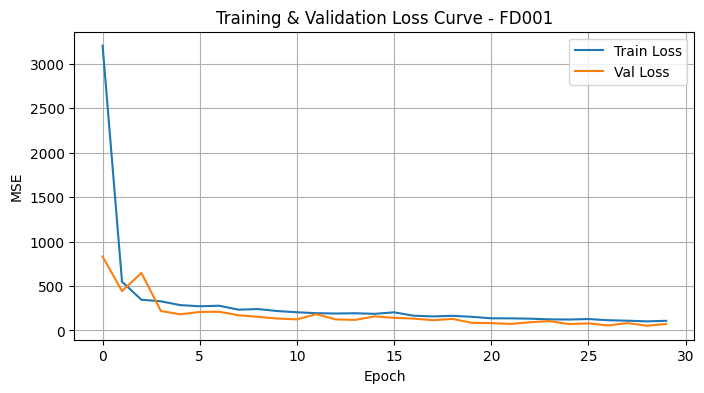

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Training & Validation Loss Curve - FD001")
plt.legend()
plt.grid(True)
plt.show()


74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step
FD001 Validation RMSE: 8.547708697341609


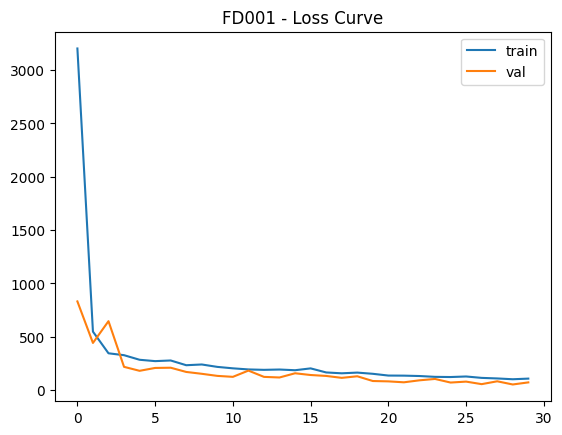

In [ ]:
import math
y_vp = model_fd001.predict(X_val).ravel()
rmse_fd001 = math.sqrt(mean_squared_error(y_val,y_vp))
print("FD001 Validation RMSE:", rmse_fd001)

plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.legend()
plt.title("FD001 - Loss Curve")
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
FD001 Test RMSE: 18.015564017676493


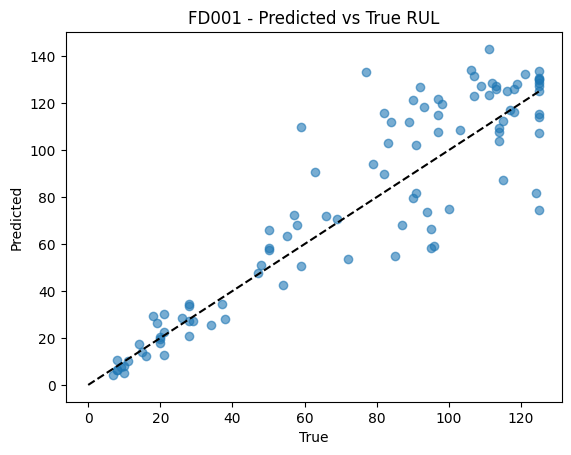

In [ ]:
df_test = read_cmapss("data/test_FD001.txt")
df_test[sensor_cols] = scaler_fd001.transform(df_test[sensor_cols])

# Last window per engine
X_test = []
for u in sorted(df_test["unit"].unique()):
    temp = df_test[df_test["unit"]==u].sort_values("cycle")[sensor_cols].values
    if len(temp) >= SEQ_LEN:
        X_test.append(temp[-SEQ_LEN:])
    else:
        pad = np.repeat(temp[0:1], SEQ_LEN - len(temp), axis=0)
        X_test.append(np.vstack([pad,temp]))

X_test = np.array(X_test)

y_true = pd.read_csv("data/RUL_FD001.txt", header=None)[0].clip(upper=CAP_RUL).values
y_pred = model_fd001.predict(X_test).ravel()

rmse_test_fd001 = math.sqrt(mean_squared_error(y_true,y_pred))
print("FD001 Test RMSE:", rmse_test_fd001)

plt.scatter(y_true,y_pred,alpha=0.6)
plt.plot([0,125],[0,125],"k--")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("FD001 - Predicted vs True RUL")
plt.show()


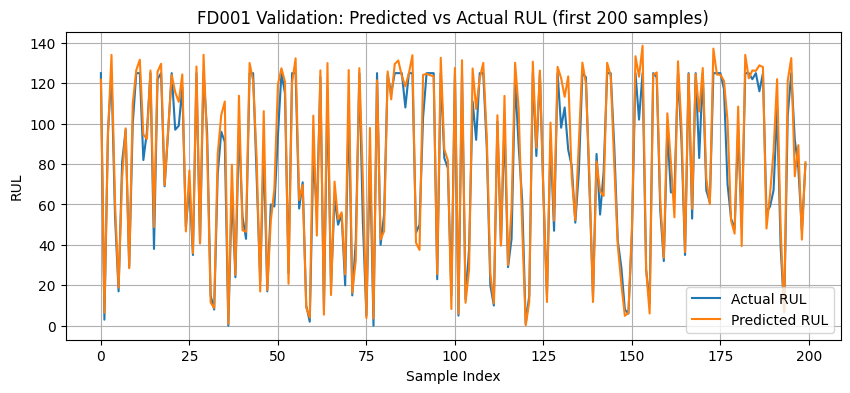

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(y_val[:200], label="Actual RUL")
plt.plot(y_val_pred[:200], label="Predicted RUL")
plt.title("FD001 Validation: Predicted vs Actual RUL (first 200 samples)")
plt.xlabel("Sample Index")
plt.ylabel("RUL")
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Test RMSE (FD001): 18.5833


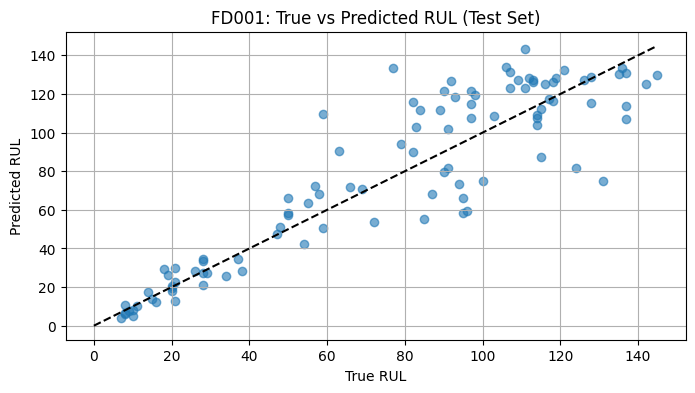

In [ ]:
# ---- FD001 Test Set Evaluation ----
test_file = os.path.join(DATA_DIR, "test_FD001.txt")
rul_file  = os.path.join(DATA_DIR, "RUL_FD001.txt")

df_test_raw = read_cmapss(test_file)
df_test_scaled = df_test_raw.copy()
df_test_scaled[sensor_cols] = scaler_fd001.transform(df_test_raw[sensor_cols].values)

# Last SEQ_LEN cycles per engine
X_test = []
test_units = sorted(df_test_scaled["unit"].unique())
for u in test_units:
    tmp = df_test_scaled[df_test_scaled["unit"] == u]
    arr = tmp[sensor_cols].values

    if arr.shape[0] >= SEQ_LEN:
        X_test.append(arr[-SEQ_LEN:])
    else:
        pad_n = SEQ_LEN - arr.shape[0]
        pad = np.vstack([arr[0]] * pad_n)
        X_test.append(np.vstack([pad, arr]))

X_test = np.array(X_test)

# True RUL
y_test_true = pd.read_csv(rul_file, header=None).values.ravel()

# Predictions
y_test_pred = model_fd001.predict(X_test).ravel()

# RMSE
test_rmse = math.sqrt(mean_squared_error(y_test_true, y_test_pred))
print(f"Test RMSE (FD001): {test_rmse:.4f}")

# Plot true vs predicted
plt.figure(figsize=(8,4))
plt.scatter(y_test_true, y_test_pred, alpha=0.6)
plt.plot([0, max(y_test_true)], [0, max(y_test_true)], 'k--')
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("FD001: True vs Predicted RUL (Test Set)")
plt.grid(True)
plt.show()


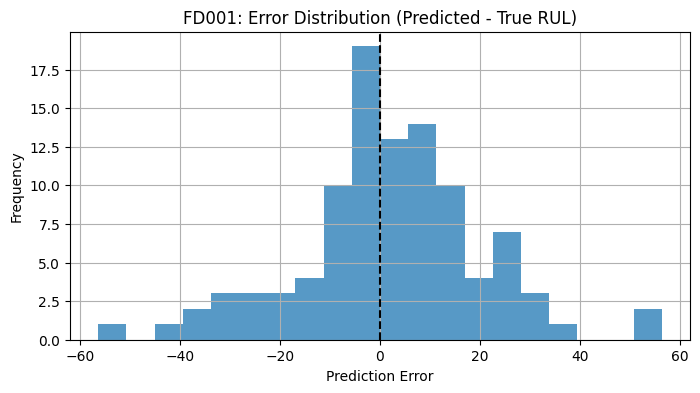

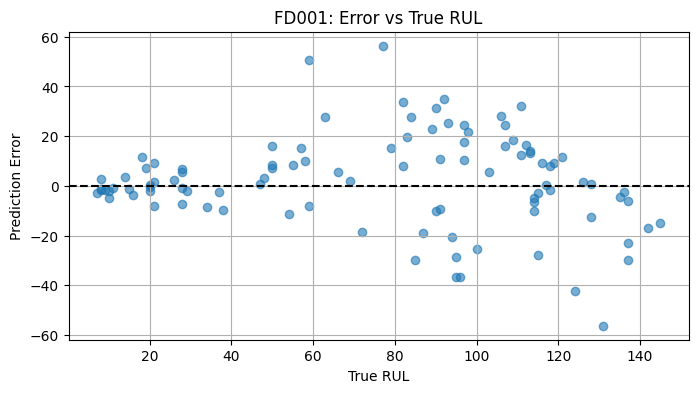

Mean Error: 2.1013900089263915
Std Dev of Error: 18.46407826007147


In [ ]:
# ---- FD001 Error Analysis ----
errors = y_test_pred - y_test_true

# Histogram of errors
plt.figure(figsize=(8,4))
plt.hist(errors, bins=20, alpha=0.75)
plt.axvline(0, color='k', linestyle='--')
plt.title("FD001: Error Distribution (Predicted - True RUL)")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Error vs True RUL
plt.figure(figsize=(8,4))
plt.scatter(y_test_true, errors, alpha=0.6)
plt.axhline(0, color='k', linestyle='--')
plt.xlabel("True RUL")
plt.ylabel("Prediction Error")
plt.title("FD001: Error vs True RUL")
plt.grid(True)
plt.show()

print("Mean Error:", np.mean(errors))
print("Std Dev of Error:", np.std(errors))


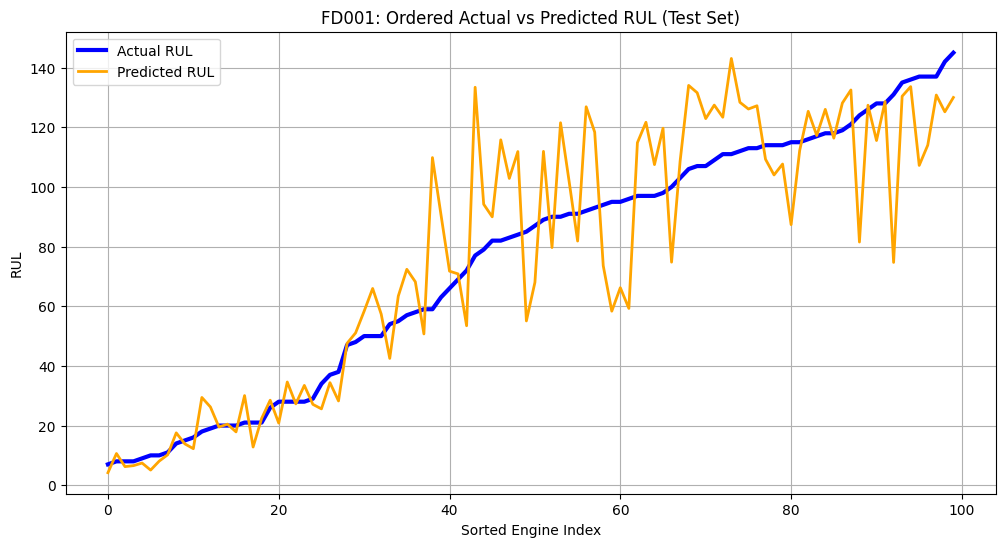

In [ ]:
# Ordered Actual vs Predicted RUL for FD001
sorted_idx = np.argsort(y_test_true)  # sort by actual RUL
y_true_sorted = y_test_true[sorted_idx]
y_pred_sorted = y_test_pred[sorted_idx]

plt.figure(figsize=(12,6))
plt.plot(y_true_sorted, label="Actual RUL", linewidth=3, color='blue')
plt.plot(y_pred_sorted, label="Predicted RUL", linewidth=2, color='orange')
plt.title("FD001: Ordered Actual vs Predicted RUL (Test Set)")
plt.xlabel("Sorted Engine Index")
plt.ylabel("RUL")
plt.grid(True)
plt.legend()
plt.show()


FD002

In [ ]:
import os
os.makedirs("data", exist_ok=True)
print("Data folder ready!")


Data folder ready!


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving test_FD002.txt to test_FD002.txt
Saving train_FD002.txt to train_FD002.txt
Saving RUL_FD002.txt to RUL_FD002.txt


In [ ]:
import os

for fname in uploaded.keys():
    os.rename(fname, os.path.join("data", fname))

print("FD002 files moved into /data folder")
print("Files now present:", os.listdir("data"))


FD002 files moved into /data folder
Files now present: ['train_FD002.txt', 'test_FD002.txt', 'RUL_FD001.txt', 'RUL_FD002.txt', 'train_FD001.txt', 'test_FD001.txt']


In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()


In [ ]:
# Load FD002 Training Data
train_fd2 = read_cmapss("data/train_FD002.txt")

# Add RUL column
def add_rul(df):
    max_cycle = df.groupby("unit")["cycle"].max().reset_index()
    max_cycle.columns = ["unit", "max_cycle"]
    df = df.merge(max_cycle, on="unit")
    df["RUL"] = df["max_cycle"] - df["cycle"]
    return df.drop(columns=["max_cycle"])

train_fd2 = add_rul(train_fd2)
print("FD002 Training data shape:", train_fd2.shape)

# Sensor + op setting columns
sensor_cols = [c for c in train_fd2.columns if c.startswith("s") or c.startswith("op_setting")]

# Cap RUL to reduce imbalance
train_fd2["RUL_capped"] = train_fd2["RUL"].clip(upper=125)

# Scale features
from sklearn.preprocessing import StandardScaler
scaler_fd2 = StandardScaler()
train_fd2[sensor_cols] = scaler_fd2.fit_transform(train_fd2[sensor_cols])


FD002 Training data shape: (53759, 27)


In [ ]:
def create_sequences(df, seq_len=50):
    X, y = [], []
    for unit in df["unit"].unique():
        unit_data = df[df["unit"] == unit].sort_values("cycle")
        features = unit_data[sensor_cols].values
        rul_vals = unit_data["RUL_capped"].values

        for i in range(len(features) - seq_len + 1):
            X.append(features[i:i+seq_len])
            y.append(rul_vals[i+seq_len-1])

    return np.array(X), np.array(y)

SEQ_LEN = 50
X_fd2, y_fd2 = create_sequences(train_fd2, SEQ_LEN)

print("FD002 Sequence set shape:", X_fd2.shape, y_fd2.shape)


FD002 Sequence set shape: (41019, 50, 24) (41019,)


In [ ]:
from sklearn.model_selection import train_test_split

X_train_fd2, X_val_fd2, y_train_fd2, y_val_fd2 = train_test_split(
    X_fd2, y_fd2, test_size=0.15, random_state=42, shuffle=True
)

print(X_train_fd2.shape, X_val_fd2.shape)


(34866, 50, 24) (6153, 50, 24)


In [ ]:
model_fd2 = Sequential([
    GRU(128, input_shape=(SEQ_LEN, len(sensor_cols))),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dense(1)
])

model_fd2.compile(optimizer="adam", loss="mse")

checkpoint_fd2 = ModelCheckpoint("best_FD002.h5", monitor="val_loss",
                                 save_best_only=True)

history_fd2 = model_fd2.fit(
    X_train_fd2, y_train_fd2,
    validation_data=(X_val_fd2, y_val_fd2),
    epochs=30, batch_size=128,
    callbacks=[checkpoint_fd2],
    verbose=2
)

joblib.dump(scaler_fd2, "scaler_FD002.joblib")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30


273/273 - 43s - 159ms/step - loss: 2383.7725 - val_loss: 725.4766
Epoch 2/30


273/273 - 41s - 150ms/step - loss: 559.6320 - val_loss: 449.8638
Epoch 3/30


273/273 - 41s - 152ms/step - loss: 463.9208 - val_loss: 282.0140
Epoch 4/30


273/273 - 41s - 149ms/step - loss: 337.9412 - val_loss: 229.5278
Epoch 5/30


273/273 - 40s - 147ms/step - loss: 325.3711 - val_loss: 216.7983
Epoch 6/30
273/273 - 41s - 150ms/step - loss: 301.0262 - val_loss: 228.3314
Epoch 7/30


273/273 - 40s - 147ms/step - loss: 279.5057 - val_loss: 210.2937
Epoch 8/30
273/273 - 43s - 157ms/step - loss: 278.2863 - val_loss: 234.2594
Epoch 9/30
273/273 - 40s - 147ms/step - loss: 252.7806 - val_loss: 213.2906
Epoch 10/30


273/273 - 40s - 148ms/step - loss: 246.8802 - val_loss: 191.1331
Epoch 11/30
273/273 - 44s - 161ms/step - loss: 230.8429 - val_loss: 198.3724
Epoch 12/30


273/273 - 40s - 147ms/step - loss: 215.8529 - val_loss: 177.1013
Epoch 13/30


273/273 - 40s - 147ms/step - loss: 199.5010 - val_loss: 167.4203
Epoch 14/30


273/273 - 40s - 146ms/step - loss: 187.1323 - val_loss: 139.9649
Epoch 15/30


273/273 - 40s - 147ms/step - loss: 177.2756 - val_loss: 137.0670
Epoch 16/30
273/273 - 41s - 149ms/step - loss: 162.1177 - val_loss: 138.1511
Epoch 17/30


273/273 - 40s - 147ms/step - loss: 151.5912 - val_loss: 86.7632
Epoch 18/30


273/273 - 40s - 148ms/step - loss: 134.4862 - val_loss: 81.7970
Epoch 19/30


273/273 - 41s - 151ms/step - loss: 124.9000 - val_loss: 79.6255
Epoch 20/30
273/273 - 40s - 147ms/step - loss: 118.1722 - val_loss: 80.7354
Epoch 21/30


273/273 - 41s - 149ms/step - loss: 111.2123 - val_loss: 75.8711
Epoch 22/30


273/273 - 40s - 147ms/step - loss: 108.4651 - val_loss: 49.7301
Epoch 23/30
273/273 - 41s - 149ms/step - loss: 98.2214 - val_loss: 85.0857
Epoch 24/30
273/273 - 40s - 147ms/step - loss: 94.5804 - val_loss: 111.6596
Epoch 25/30


273/273 - 40s - 147ms/step - loss: 88.6820 - val_loss: 36.2861
Epoch 26/30
273/273 - 40s - 146ms/step - loss: 86.8941 - val_loss: 38.7087
Epoch 27/30
273/273 - 41s - 149ms/step - loss: 84.1248 - val_loss: 44.1141
Epoch 28/30
273/273 - 40s - 148ms/step - loss: 79.5761 - val_loss: 40.4952
Epoch 29/30


273/273 - 40s - 148ms/step - loss: 78.8679 - val_loss: 34.1444
Epoch 30/30


273/273 - 43s - 157ms/step - loss: 76.1657 - val_loss: 27.8327


['scaler_FD002.joblib']

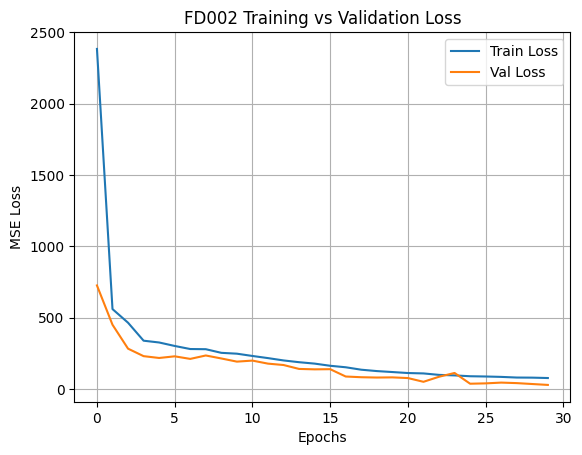

In [ ]:
plt.plot(history_fd2.history["loss"], label="Train Loss")
plt.plot(history_fd2.history["val_loss"], label="Val Loss")
plt.title("FD002 Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
y_val_pred_fd2 = model_fd2.predict(X_val_fd2).ravel()
rmse_val_fd2 = math.sqrt(mean_squared_error(y_val_fd2, y_val_pred_fd2))
print("FD002 Validation RMSE:", rmse_val_fd2)


193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step
FD002 Validation RMSE: 5.275669919543449


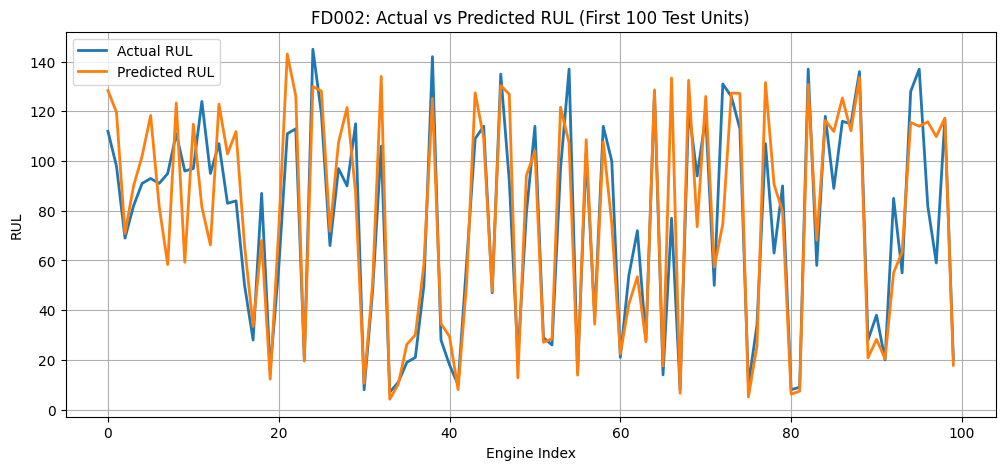

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(y_test_true[:100], label="Actual RUL", linewidth=2)
plt.plot(y_test_pred[:100], label="Predicted RUL", linewidth=2)
plt.title("FD002: Actual vs Predicted RUL (First 100 Test Units)")
plt.xlabel("Engine Index")
plt.ylabel("RUL")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Load Test data & True RUL for FD002
df_test_raw_2 = read_cmapss("data/test_FD002.txt")
true_rul_fd2 = pd.read_csv("data/RUL_FD002.txt", sep=r"\s+", header=None).values.ravel()
CAP_RUL = 125
true_rul_fd2 = np.clip(true_rul_fd2, None, CAP_RUL)

# Scale test data using saved scaler
df_test_raw_2[sensor_cols] = scaler_fd2.transform(df_test_raw_2[sensor_cols])

# Create sequences for each test unit
X_test_fd2 = []
units_fd2 = sorted(df_test_raw_2["unit"].unique())

for unit in units_fd2:
    temp_df = df_test_raw_2[df_test_raw_2["unit"] == unit].sort_values("cycle")
    arr = temp_df[sensor_cols].values

    if len(arr) >= SEQ_LEN:
        X_test_fd2.append(arr[-SEQ_LEN:])
    else:
        # Pad start with first row if shorter
        pad_len = SEQ_LEN - len(arr)
        pad = np.repeat(arr[0:1], pad_len, axis=0)
        X_test_fd2.append(np.vstack([pad, arr]))

X_test_fd2 = np.array(X_test_fd2)

# Predictions
pred_rul_fd2 = model_fd2.predict(X_test_fd2).ravel()

# RMSE on Test set
rmse_test_fd2 = math.sqrt(mean_squared_error(true_rul_fd2, pred_rul_fd2))
print("\n📌 FD002 Test RMSE:", rmse_test_fd2)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

📌 FD002 Test RMSE: 17.120428435766986


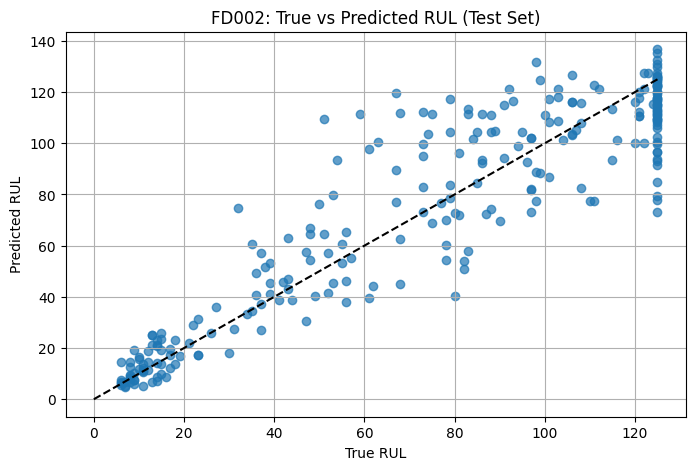

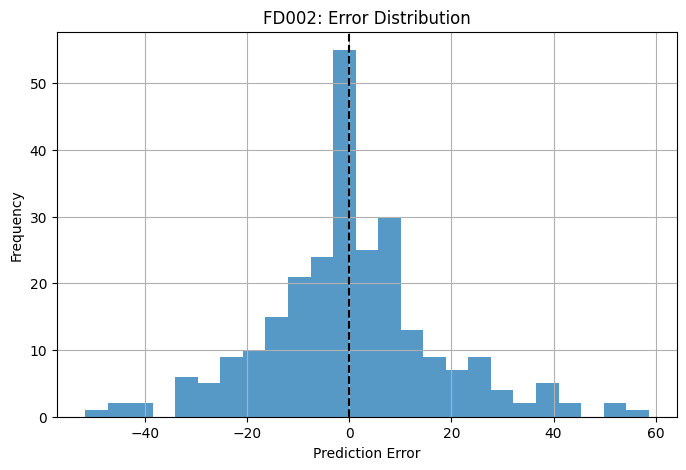

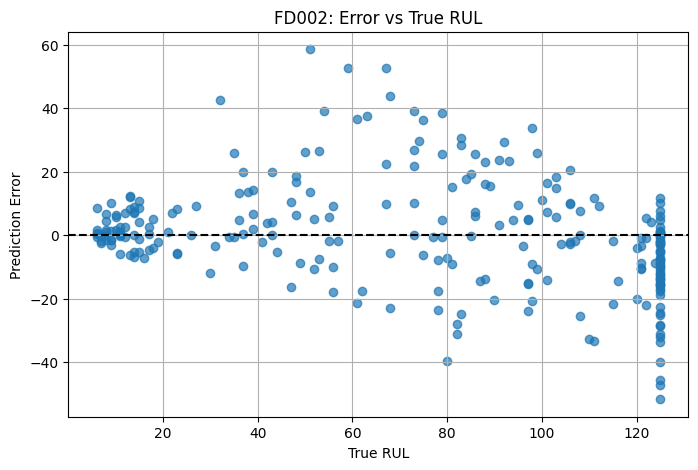

Mean Error: 0.3683283540733072
Std Dev Error: 17.11646609374836


In [ ]:
# Error calculations
errors_fd2 = pred_rul_fd2 - true_rul_fd2

# 1️⃣ True vs Predicted RUL Scatter
plt.figure(figsize=(8,5))
plt.scatter(true_rul_fd2, pred_rul_fd2, alpha=0.7)
plt.plot([0, 125], [0, 125], 'k--')
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("FD002: True vs Predicted RUL (Test Set)")
plt.grid(True)
plt.show()

# 2️⃣ Error Distribution (Histogram)
plt.figure(figsize=(8,5))
plt.hist(errors_fd2, bins=25, alpha=0.75)
plt.axvline(0, linestyle="--", color="black")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("FD002: Error Distribution")
plt.grid(True)
plt.show()

# 3️⃣ Error vs True RUL scatter
plt.figure(figsize=(8,5))
plt.scatter(true_rul_fd2, errors_fd2, alpha=0.7)
plt.axhline(0, linestyle="--", color="black")
plt.xlabel("True RUL")
plt.ylabel("Prediction Error")
plt.title("FD002: Error vs True RUL")
plt.grid(True)
plt.show()

print("Mean Error:", np.mean(errors_fd2))
print("Std Dev Error:", np.std(errors_fd2))


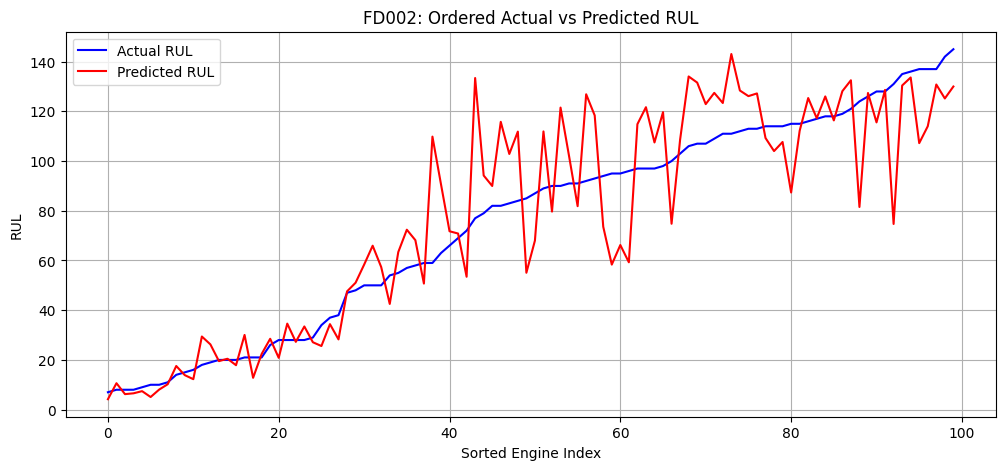

In [ ]:
sorted_idx = np.argsort(y_test_true)

plt.figure(figsize=(12,5))
plt.plot(np.array(y_test_true)[sorted_idx], 'b-', label="Actual RUL")
plt.plot(np.array(y_test_pred)[sorted_idx], 'r-', label="Predicted RUL")
plt.title("FD002: Ordered Actual vs Predicted RUL")
plt.xlabel("Sorted Engine Index")
plt.ylabel("RUL")
plt.legend()
plt.grid(True)
plt.show()


FD003

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving test_FD003.txt to test_FD003.txt
Saving train_FD003.txt to train_FD003.txt
Saving RUL_FD003.txt to RUL_FD003.txt


In [ ]:
for fn in uploaded.keys():
    os.rename(fn, os.path.join("data", fn))

print("Files successfully moved to data/:")
print(os.listdir("data"))


Files successfully moved to data/:
['test_FD003.txt', 'train_FD002.txt', 'test_FD002.txt', 'RUL_FD001.txt', 'train_FD003.txt', 'RUL_FD002.txt', 'train_FD001.txt', 'test_FD001.txt', 'RUL_FD003.txt']


In [ ]:
import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import joblib

tf.keras.backend.clear_session()

DATA_DIR = "./data"
print("Files in data:", os.listdir(DATA_DIR))


Files in data: ['test_FD003.txt', 'train_FD002.txt', 'test_FD002.txt', 'RUL_FD001.txt', 'train_FD003.txt', 'RUL_FD002.txt', 'train_FD001.txt', 'test_FD001.txt', 'RUL_FD003.txt']


In [ ]:
def read_cmapss(file_path):
    col_names = ["unit", "cycle",
                 "op_setting_1", "op_setting_2", "op_setting_3"] \
                + [f"s{i}" for i in range(1, 22)]
    df = pd.read_csv(file_path, sep=r"\s+", header=None, names=col_names)
    return df


In [ ]:
# Load FD003 training data
train_fd3 = read_cmapss(os.path.join(DATA_DIR, "train_FD003.txt"))
print("FD003 train shape:", train_fd3.shape)

# Add RUL = max_cycle - current_cycle
max_cycle_fd3 = train_fd3.groupby("unit")["cycle"].max().reset_index()
max_cycle_fd3.columns = ["unit", "max_cycle"]

train_fd3 = train_fd3.merge(max_cycle_fd3, on="unit", how="left")
train_fd3["RUL"] = train_fd3["max_cycle"] - train_fd3["cycle"]
train_fd3.drop("max_cycle", axis=1, inplace=True)

train_fd3.head()


FD003 train shape: (24720, 26)


,unit,cycle,op_setting_1,op_setting_2,op_setting_3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537,258
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491,257
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669,256
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951,255
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583,254


In [ ]:
CAP_RUL = 125
SEQ_LEN = 50

sensor_cols_fd3 = [c for c in train_fd3.columns
                   if c.startswith("s") or c.startswith("op_setting")]

# Cap RUL to reduce effect of very large lifetimes
train_fd3["RUL_capped"] = train_fd3["RUL"].clip(upper=CAP_RUL)

# Scale sensor + op_setting features
scaler_fd3 = StandardScaler()
train_fd3[sensor_cols_fd3] = scaler_fd3.fit_transform(train_fd3[sensor_cols_fd3])

print("Number of sensors/op settings (FD003):", len(sensor_cols_fd3))
print("Any missing values?\n", train_fd3.isna().sum().sum(), "(0 means none)")


Number of sensors/op settings (FD003): 24
Any missing values?
 0 (0 means none)


In [ ]:
def create_sequences_fd3(df, seq_len, sensor_cols):
    X, y = [], []
    for u in df["unit"].unique():
        tmp = df[df["unit"] == u].sort_values("cycle")
        data = tmp[sensor_cols].values
        labels = tmp["RUL_capped"].values

        if len(data) < seq_len:
            continue

        for i in range(len(data) - seq_len + 1):
            X.append(data[i:i+seq_len])
            y.append(labels[i+seq_len-1])
    return np.array(X), np.array(y)

X_fd3, y_fd3 = create_sequences_fd3(train_fd3, SEQ_LEN, sensor_cols_fd3)
print("FD003 sequence data:", X_fd3.shape, y_fd3.shape)


FD003 sequence data: (19820, 50, 24) (19820,)


In [ ]:
X_train_fd3, X_val_fd3, y_train_fd3, y_val_fd3 = train_test_split(
    X_fd3, y_fd3, test_size=0.15, random_state=42, shuffle=True
)

print("FD003 train:", X_train_fd3.shape,
      "val:", X_val_fd3.shape)


FD003 train: (16847, 50, 24) val: (2973, 50, 24)


In [ ]:
tf.keras.backend.clear_session()

model_fd3 = Sequential([
    # First GRU layer (returns sequences to feed next GRU)
    GRU(128, return_sequences=True,
        input_shape=(SEQ_LEN, len(sensor_cols_fd3))),
    Dropout(0.3),

    # Second GRU layer (compress full sequence into one vector)
    GRU(64, return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),

    # Dense layers for regression
    Dense(64, activation="relu"),
    Dense(1)   # linear output for RUL
])

model_fd3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss="mse")

model_fd3.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 50, 128)        │        59,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,865 (394.00 KB)

 Trainable params: 100,737 (393.50 KB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
callbacks_fd3 = [
    EarlyStopping(monitor="val_loss", patience=8,
                  restore_best_weights=True, verbose=1),
    ModelCheckpoint("best_FD003.h5", monitor="val_loss",
                    save_best_only=True, verbose=1)
]

history_fd3 = model_fd3.fit(
    X_train_fd3, y_train_fd3,
    validation_data=(X_val_fd3, y_val_fd3),
    epochs=40,
    batch_size=128,
    callbacks=callbacks_fd3,
    verbose=2
)

joblib.dump(scaler_fd3, "scaler_FD003.joblib")


Epoch 1/40

Epoch 1: val_loss improved from inf to 1057.48767, saving model to best_FD003.h5


132/132 - 43s - 325ms/step - loss: 5120.0947 - val_loss: 1057.4877
Epoch 2/40

Epoch 2: val_loss improved from 1057.48767 to 288.23590, saving model to best_FD003.h5


132/132 - 42s - 315ms/step - loss: 574.9333 - val_loss: 288.2359
Epoch 3/40

Epoch 3: val_loss improved from 288.23590 to 201.67850, saving model to best_FD003.h5


132/132 - 35s - 263ms/step - loss: 358.7047 - val_loss: 201.6785
Epoch 4/40

Epoch 4: val_loss improved from 201.67850 to 159.26140, saving model to best_FD003.h5


132/132 - 36s - 275ms/step - loss: 290.2821 - val_loss: 159.2614
Epoch 5/40

Epoch 5: val_loss did not improve from 159.26140
132/132 - 37s - 280ms/step - loss: 278.7847 - val_loss: 259.0517
Epoch 6/40

Epoch 6: val_loss improved from 159.26140 to 125.93890, saving model to best_FD003.h5


132/132 - 35s - 263ms/step - loss: 252.5936 - val_loss: 125.9389
Epoch 7/40

Epoch 7: val_loss did not improve from 125.93890
132/132 - 36s - 274ms/step - loss: 255.1361 - val_loss: 142.8535
Epoch 8/40

Epoch 8: val_loss improved from 125.93890 to 104.17025, saving model to best_FD003.h5


132/132 - 36s - 276ms/step - loss: 239.1782 - val_loss: 104.1702
Epoch 9/40

Epoch 9: val_loss did not improve from 104.17025
132/132 - 35s - 261ms/step - loss: 242.7044 - val_loss: 132.6566
Epoch 10/40

Epoch 10: val_loss did not improve from 104.17025
132/132 - 42s - 316ms/step - loss: 233.4226 - val_loss: 113.3381
Epoch 11/40

Epoch 11: val_loss improved from 104.17025 to 90.19761, saving model to best_FD003.h5


132/132 - 37s - 278ms/step - loss: 219.4735 - val_loss: 90.1976
Epoch 12/40

Epoch 12: val_loss did not improve from 90.19761
132/132 - 36s - 275ms/step - loss: 213.3831 - val_loss: 96.8019
Epoch 13/40

Epoch 13: val_loss did not improve from 90.19761
132/132 - 41s - 310ms/step - loss: 213.5548 - val_loss: 104.9661
Epoch 14/40

Epoch 14: val_loss did not improve from 90.19761
132/132 - 36s - 274ms/step - loss: 210.0090 - val_loss: 124.2478
Epoch 15/40

Epoch 15: val_loss did not improve from 90.19761
132/132 - 35s - 263ms/step - loss: 201.9312 - val_loss: 137.0126
Epoch 16/40

Epoch 16: val_loss improved from 90.19761 to 71.84692, saving model to best_FD003.h5


132/132 - 36s - 276ms/step - loss: 198.5239 - val_loss: 71.8469
Epoch 17/40

Epoch 17: val_loss did not improve from 71.84692
132/132 - 41s - 309ms/step - loss: 206.8683 - val_loss: 99.2091
Epoch 18/40

Epoch 18: val_loss did not improve from 71.84692
132/132 - 41s - 311ms/step - loss: 184.0662 - val_loss: 86.3089
Epoch 19/40

Epoch 19: val_loss improved from 71.84692 to 58.59732, saving model to best_FD003.h5


132/132 - 36s - 275ms/step - loss: 177.6549 - val_loss: 58.5973
Epoch 20/40

Epoch 20: val_loss did not improve from 58.59732
132/132 - 35s - 269ms/step - loss: 175.6892 - val_loss: 96.7066
Epoch 21/40

Epoch 21: val_loss did not improve from 58.59732
132/132 - 40s - 303ms/step - loss: 772.7920 - val_loss: 240.7025
Epoch 22/40

Epoch 22: val_loss did not improve from 58.59732
132/132 - 36s - 275ms/step - loss: 338.6938 - val_loss: 628.6818
Epoch 23/40

Epoch 23: val_loss did not improve from 58.59732
132/132 - 36s - 270ms/step - loss: 322.4125 - val_loss: 257.4656
Epoch 24/40

Epoch 24: val_loss did not improve from 58.59732
132/132 - 35s - 267ms/step - loss: 240.1239 - val_loss: 132.6621
Epoch 25/40

Epoch 25: val_loss did not improve from 58.59732
132/132 - 36s - 276ms/step - loss: 245.9392 - val_loss: 152.9832
Epoch 26/40

Epoch 26: val_loss did not improve from 58.59732
132/132 - 41s - 310ms/step - loss: 220.3348 - val_loss: 82.7620
Epoch 27/40

Epoch 27: val_loss did not improve f

['scaler_FD003.joblib']

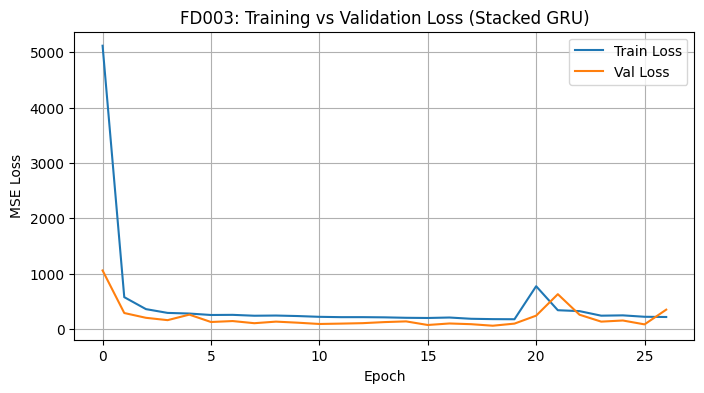

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history_fd3.history["loss"], label="Train Loss")
plt.plot(history_fd3.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("FD003: Training vs Validation Loss (Stacked GRU)")
plt.legend()
plt.grid(True)
plt.show()


93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step
FD003 Validation RMSE: 7.654888919594973


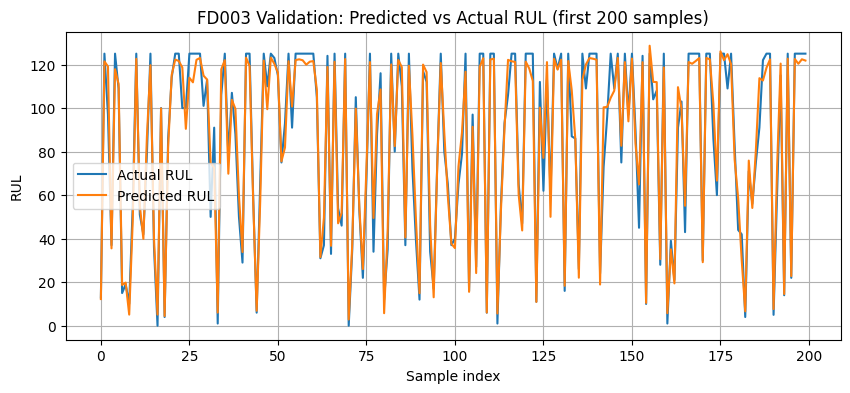

In [ ]:
y_val_pred_fd3 = model_fd3.predict(X_val_fd3).ravel()
rmse_val_fd3 = math.sqrt(mean_squared_error(y_val_fd3, y_val_pred_fd3))
print("FD003 Validation RMSE:", rmse_val_fd3)

# optional: first 200 validation samples
plt.figure(figsize=(10,4))
plt.plot(y_val_fd3[:200], label="Actual RUL")
plt.plot(y_val_pred_fd3[:200], label="Predicted RUL")
plt.title("FD003 Validation: Predicted vs Actual RUL (first 200 samples)")
plt.xlabel("Sample index")
plt.ylabel("RUL")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Load and scale test data
test_fd3 = read_cmapss(os.path.join(DATA_DIR, "test_FD003.txt"))
test_fd3[sensor_cols_fd3] = scaler_fd3.transform(test_fd3[sensor_cols_fd3])

X_test_fd3 = []
units_fd3 = sorted(test_fd3["unit"].unique())

for u in units_fd3:
    tmp = test_fd3[test_fd3["unit"] == u].sort_values("cycle")
    arr = tmp[sensor_cols_fd3].values

    if len(arr) >= SEQ_LEN:
        X_test_fd3.append(arr[-SEQ_LEN:])
    else:
        pad_len = SEQ_LEN - len(arr)
        pad = np.repeat(arr[0:1], pad_len, axis=0)
        X_test_fd3.append(np.vstack([pad, arr]))

X_test_fd3 = np.array(X_test_fd3)

# True RULs
y_test_true_fd3 = pd.read_csv(
    os.path.join(DATA_DIR, "RUL_FD003.txt"),
    sep=r"\s+", header=None
).values.ravel()
y_test_true_fd3 = np.clip(y_test_true_fd3, None, CAP_RUL)

# Predictions
y_test_pred_fd3 = model_fd3.predict(X_test_fd3).ravel()

rmse_test_fd3 = math.sqrt(mean_squared_error(y_test_true_fd3, y_test_pred_fd3))
print("📌 FD003 Test RMSE:", rmse_test_fd3)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
📌 FD003 Test RMSE: 13.401738614836159


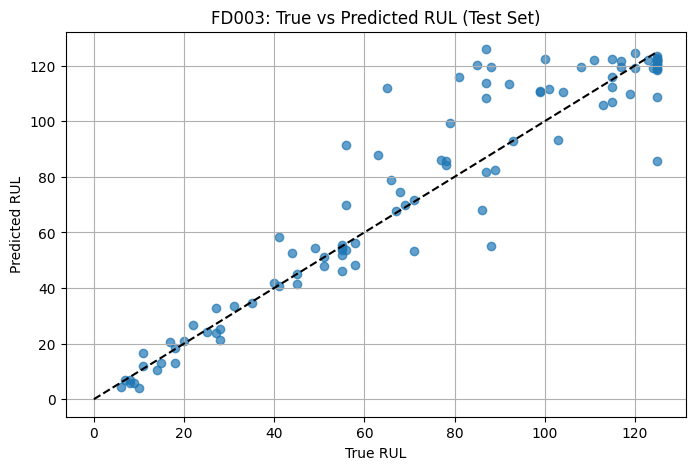

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(y_test_true_fd3, y_test_pred_fd3, alpha=0.7)
plt.plot([0, CAP_RUL], [0, CAP_RUL], "k--")
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("FD003: True vs Predicted RUL (Test Set)")
plt.grid(True)
plt.show()


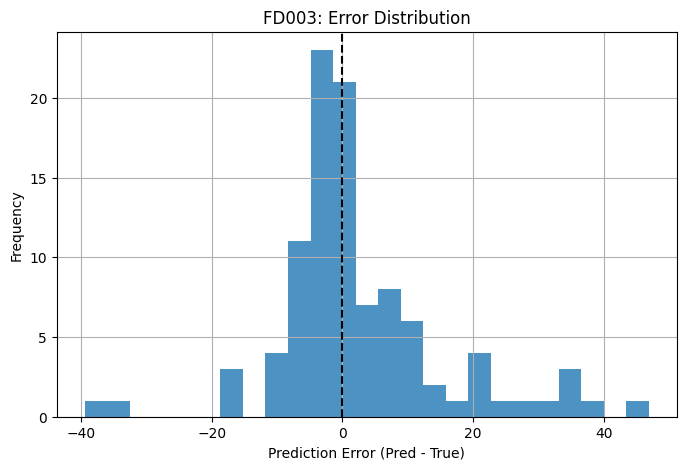

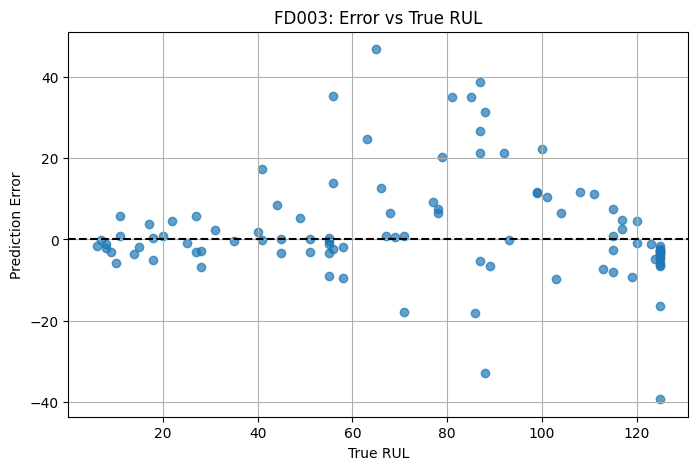

Mean Error FD003: 2.5479733991622924
Std Dev Error FD003: 13.15729623591612


In [ ]:
errors_fd3 = y_test_pred_fd3 - y_test_true_fd3

plt.figure(figsize=(8,5))
plt.hist(errors_fd3, bins=25, alpha=0.8)
plt.axvline(0, color='k', linestyle='--')
plt.xlabel("Prediction Error (Pred - True)")
plt.ylabel("Frequency")
plt.title("FD003: Error Distribution")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.scatter(y_test_true_fd3, errors_fd3, alpha=0.7)
plt.axhline(0, color='k', linestyle='--')
plt.xlabel("True RUL")
plt.ylabel("Prediction Error")
plt.title("FD003: Error vs True RUL")
plt.grid(True)
plt.show()

print("Mean Error FD003:", np.mean(errors_fd3))
print("Std Dev Error FD003:", np.std(errors_fd3))


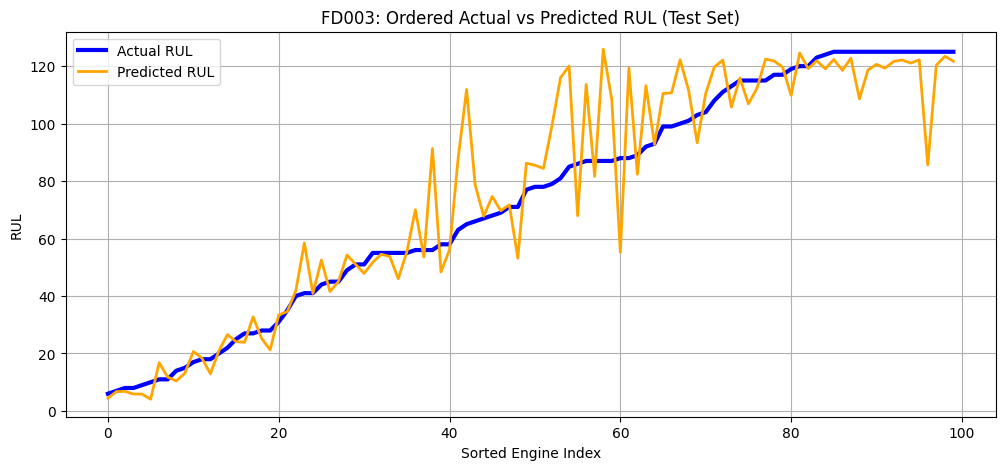

In [ ]:
sorted_idx_fd3 = np.argsort(y_test_true_fd3)
true_sorted_fd3 = y_test_true_fd3[sorted_idx_fd3]
pred_sorted_fd3 = y_test_pred_fd3[sorted_idx_fd3]

plt.figure(figsize=(12,5))
plt.plot(true_sorted_fd3, label="Actual RUL", linewidth=3, color="blue")
plt.plot(pred_sorted_fd3, label="Predicted RUL", linewidth=2, color="orange")
plt.xlabel("Sorted Engine Index")
plt.ylabel("RUL")
plt.title("FD003: Ordered Actual vs Predicted RUL (Test Set)")
plt.grid(True)
plt.legend()
plt.show()


FD004


In [ ]:
from google.colab import files
uploaded = files.upload()

import os
os.makedirs("data", exist_ok=True)

for fname in uploaded.keys():
    os.replace(fname, os.path.join("data", fname))

print("Files now present:", os.listdir("data"))


Saving test_FD004.txt to test_FD004.txt
Saving train_FD004.txt to train_FD004.txt
Saving RUL_FD004.txt to RUL_FD004.txt
Files now present: ['test_FD004.txt', 'test_FD003.txt', 'train_FD002.txt', 'train_FD004.txt', 'test_FD002.txt', 'RUL_FD001.txt', 'train_FD003.txt', 'RUL_FD002.txt', 'RUL_FD004.txt', 'train_FD001.txt', 'test_FD001.txt', 'RUL_FD003.txt']


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import joblib
import math


In [ ]:
def read_cmapss(fp):
    col_names = ["unit", "cycle",
                 "op1", "op2", "op3"] + [f"s{i}" for i in range(1,22)]
    return pd.read_csv(fp, sep=r"\s+", header=None, names=col_names)


In [ ]:
train_fd4 = read_cmapss("data/train_FD004.txt")

max_cycle = train_fd4.groupby("unit")["cycle"].max()
train_fd4 = train_fd4.merge(max_cycle, on="unit", suffixes=("","_max"))
train_fd4["RUL"] = train_fd4["cycle_max"] - train_fd4["cycle"]
train_fd4.drop(columns=["cycle_max"], inplace=True)

train_fd4.head()


,unit,cycle,op1,op2,op3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,320
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,319
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,318
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,317
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,316


In [ ]:
sensor_cols = [c for c in train_fd4.columns if c.startswith("s") or c.startswith("op")]
train_fd4["RUL"] = train_fd4["RUL"].clip(upper=125)

scaler_fd4 = StandardScaler()
train_fd4[sensor_cols] = scaler_fd4.fit_transform(train_fd4[sensor_cols])
joblib.dump(scaler_fd4, "scaler_FD004.joblib")


['scaler_FD004.joblib']

In [ ]:
SEQ_LEN = 50

def create_sequences(df):
    X, y = [], []
    for u in df["unit"].unique():
        tmp = df[df["unit"] == u].sort_values("cycle")
        values = tmp[sensor_cols].values
        rul = tmp["RUL"].values
        for i in range(len(tmp)-SEQ_LEN):
            X.append(values[i:i+SEQ_LEN])
            y.append(rul[i+SEQ_LEN-1])
    return np.array(X), np.array(y)

X_fd4, y_fd4 = create_sequences(train_fd4)

print(X_fd4.shape, y_fd4.shape)


(48799, 50, 24) (48799,)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_fd4, y_fd4, test_size=0.15, shuffle=True, random_state=42)

print(X_train.shape, X_val.shape)


(41479, 50, 24) (7320, 50, 24)


In [ ]:
def build_stacked_gru():
    model = Sequential([
        GRU(128, return_sequences=True, input_shape=(SEQ_LEN, len(sensor_cols))),
        Dropout(0.3),
        GRU(64, return_sequences=False),
        BatchNormalization(),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')
    return model

model_fd4 = build_stacked_gru()
model_fd4.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 50, 128)        │        59,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,753 (385.75 KB)

 Trainable params: 98,625 (385.25 KB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint("best_FD004.h5", save_best_only=True, monitor='val_loss')
]

history = model_fd4.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=128,
    callbacks=callbacks,
    verbose=2
)


Epoch 1/30


325/325 - 94s - 289ms/step - loss: 3732.1038 - val_loss: 1082.6431
Epoch 2/30


325/325 - 90s - 277ms/step - loss: 792.0292 - val_loss: 633.5099
Epoch 3/30
325/325 - 88s - 272ms/step - loss: 699.5792 - val_loss: 794.9344
Epoch 4/30


325/325 - 89s - 275ms/step - loss: 523.1981 - val_loss: 435.6347
Epoch 5/30


325/325 - 88s - 272ms/step - loss: 448.5200 - val_loss: 371.9175
Epoch 6/30
325/325 - 88s - 272ms/step - loss: 395.8982 - val_loss: 497.4131
Epoch 7/30
325/325 - 141s - 434ms/step - loss: 341.2593 - val_loss: 407.7713
Epoch 8/30


325/325 - 89s - 275ms/step - loss: 319.6804 - val_loss: 259.7498
Epoch 9/30
325/325 - 88s - 269ms/step - loss: 293.3954 - val_loss: 309.5236
Epoch 10/30
325/325 - 89s - 275ms/step - loss: 281.3758 - val_loss: 268.5049
Epoch 11/30


325/325 - 89s - 273ms/step - loss: 272.3536 - val_loss: 236.5780
Epoch 12/30


325/325 - 88s - 272ms/step - loss: 254.5855 - val_loss: 220.1463
Epoch 13/30
325/325 - 90s - 276ms/step - loss: 250.8187 - val_loss: 229.0349
Epoch 14/30
325/325 - 89s - 273ms/step - loss: 255.8008 - val_loss: 234.7485
Epoch 15/30
325/325 - 89s - 273ms/step - loss: 235.2973 - val_loss: 582.0479
Epoch 16/30


325/325 - 94s - 290ms/step - loss: 235.5376 - val_loss: 217.0331
Epoch 17/30


325/325 - 89s - 275ms/step - loss: 222.8863 - val_loss: 202.0621
Epoch 18/30
325/325 - 88s - 270ms/step - loss: 215.0799 - val_loss: 244.4123
Epoch 19/30


325/325 - 89s - 275ms/step - loss: 208.6532 - val_loss: 197.3860
Epoch 20/30


325/325 - 142s - 437ms/step - loss: 199.3828 - val_loss: 185.2757
Epoch 21/30
325/325 - 87s - 269ms/step - loss: 187.7276 - val_loss: 228.2512
Epoch 22/30


325/325 - 143s - 441ms/step - loss: 183.2265 - val_loss: 159.5417
Epoch 23/30
325/325 - 89s - 275ms/step - loss: 165.7311 - val_loss: 210.2228
Epoch 24/30


325/325 - 140s - 431ms/step - loss: 153.4545 - val_loss: 131.4317
Epoch 25/30
325/325 - 142s - 437ms/step - loss: 136.1649 - val_loss: 149.7191
Epoch 26/30


325/325 - 89s - 275ms/step - loss: 122.5413 - val_loss: 115.1895
Epoch 27/30
325/325 - 88s - 269ms/step - loss: 107.4594 - val_loss: 160.3423
Epoch 28/30


325/325 - 90s - 276ms/step - loss: 92.6924 - val_loss: 80.4979
Epoch 29/30


325/325 - 94s - 289ms/step - loss: 83.1631 - val_loss: 70.8712
Epoch 30/30
325/325 - 89s - 275ms/step - loss: 71.5039 - val_loss: 103.3528


In [ ]:
y_val_pred = model_fd4.predict(X_val).ravel()
rmse_val_fd4 = math.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"FD004 Validation RMSE: {rmse_val_fd4:.4f}")


229/229 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step
FD004 Validation RMSE: 8.4185


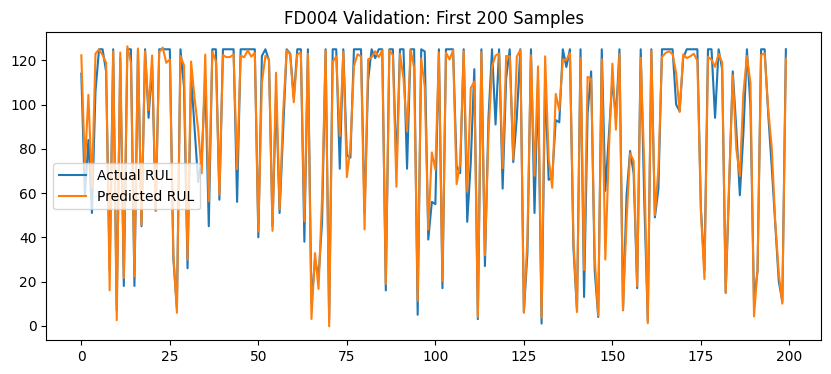

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(y_val[:200], label="Actual RUL")
plt.plot(y_val_pred[:200], label="Predicted RUL")
plt.legend(); plt.title("FD004 Validation: First 200 Samples")
plt.show()


In [ ]:
df_test = read_cmapss("data/test_FD004.txt")
df_test[sensor_cols] = scaler_fd4.transform(df_test[sensor_cols])

X_test = []
for u in df_test["unit"].unique():
    tmp = df_test[df_test["unit"] == u].sort_values("cycle")
    arr = tmp[sensor_cols].values
    if len(arr) >= SEQ_LEN:
        X_test.append(arr[-SEQ_LEN:])
    else:
        pad = np.repeat(arr[0:1], SEQ_LEN-len(arr), axis=0)
        X_test.append(np.vstack((pad, arr)))

X_test = np.array(X_test)
y_test_true = pd.read_csv("data/RUL_FD004.txt", header=None).values.ravel().clip(125)
y_test_pred = model_fd4.predict(X_test).ravel()

rmse_test_fd4 = math.sqrt(mean_squared_error(y_test_true, y_test_pred))
print(f"📌 FD004 Test RMSE: {rmse_test_fd4:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
📌 FD004 Test RMSE: 64.7542


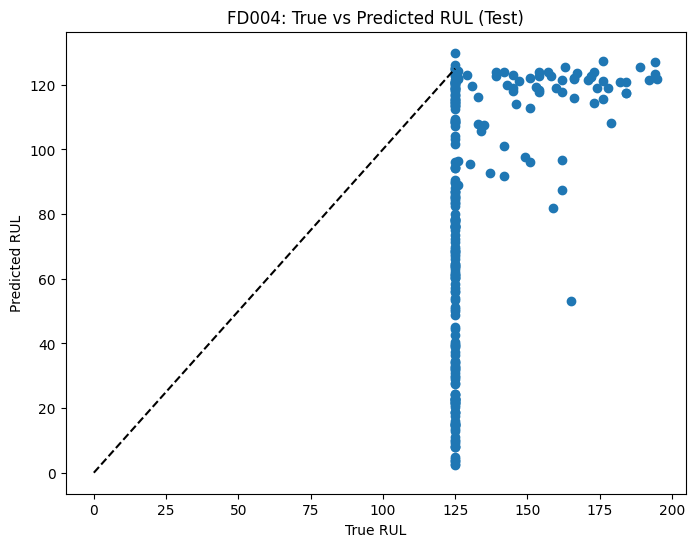

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(y_test_true, y_test_pred)
plt.plot([0,125],[0,125],'k--')
plt.xlabel("True RUL"); plt.ylabel("Predicted RUL")
plt.title("FD004: True vs Predicted RUL (Test)")
plt.show()


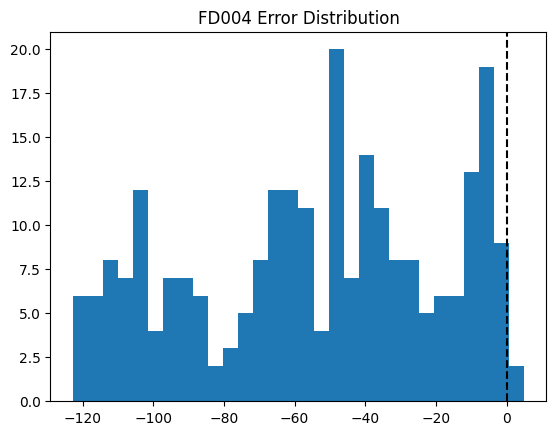

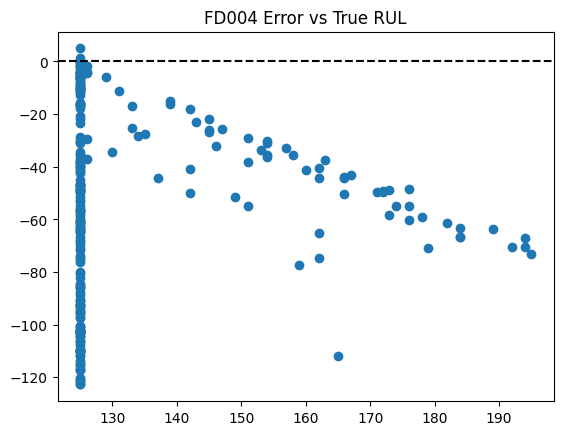

Mean Error: -54.12789434579111
Std Dev Error: 35.54265727361118


In [ ]:
errors = y_test_pred - y_test_true
plt.hist(errors, bins=30)
plt.axvline(x=0, linestyle="--", color="black")
plt.title("FD004 Error Distribution")
plt.show()

plt.scatter(y_test_true, errors)
plt.axhline(y=0, linestyle="--", color="black")
plt.title("FD004 Error vs True RUL")
plt.show()

print("Mean Error:", np.mean(errors))
print("Std Dev Error:", np.std(errors))


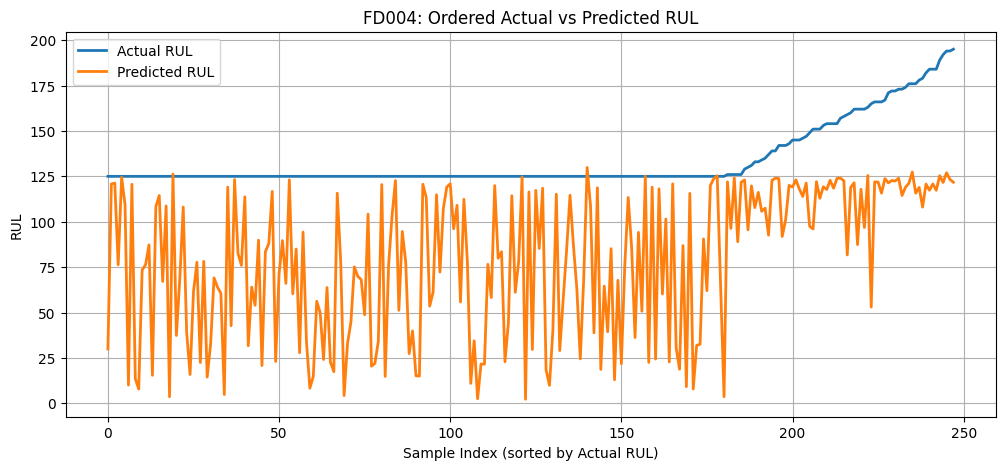

In [ ]:
# FD004 Ordered Actual vs Predicted RUL Plot

# Sort results by actual RUL for better visualization
sort_idx_fd4 = np.argsort(y_test_true)

plt.figure(figsize=(12,5))
plt.plot(np.array(y_test_true)[sort_idx_fd4], label="Actual RUL", linewidth=2)
plt.plot(np.array(y_test_pred)[sort_idx_fd4], label="Predicted RUL", linewidth=2)

plt.title("FD004: Ordered Actual vs Predicted RUL")
plt.xlabel("Sample Index (sorted by Actual RUL)")
plt.ylabel("RUL")
plt.legend()
plt.grid(True)
plt.show()
